# Notebook 2: Pre-compute echo-top variable and store back to FDB

In the previous notebooks we demonstrated how users can compute various reprojections and derived data from raw model data. However, this approach may lack efficiency when multiple users or downstream applications need to perform the same Swiss grid reprojection or interpolation to pressure levels on identical data. To optimize the process for widely beneficial and frequently reused data transformations, we aim to pre-compute and **store the results back into FDB** (write access requires user to be in group s83). 

## Configuring Access to FDB

In [1]:
from meteodatalab import mars, mch_model_data


## Querying Data

In [2]:
from datetime import datetime, timedelta

# Current time
now = datetime.now()

# Subtract 12 hours
past_time = now - timedelta(hours=12)

# Round down to the nearest multiple of 3
rounded_hour = (past_time.hour // 3) * 3
rounded_time = past_time.replace(hour=rounded_hour, minute=0, second=0, microsecond=0)

# Format as YYYYMMDD and HHMM
date = rounded_time.strftime('%Y%m%d')
time = rounded_time.strftime('%H%M')
date,time

('20250704', '0900')

In [7]:
request_dbz = mars.Request(
    param=["DBZ","T"],
    date=date,
    time=time,
    number=0,
    step=6,
    levtype=mars.LevType.MODEL_LEVEL,
    levelist=tuple(range(1, 81)),
    model=mars.Model.ICON_CH1_EPS,
)
request_hhl = mars.Request(
    param="HHL",
    date=date,
    time=time,
    number=0,
    step=0,
    levtype=mars.LevType.MODEL_LEVEL,
    levelist=tuple(range(1, 82)),
    model=mars.Model.ICON_CH1_EPS,
)


In [8]:
ds = mch_model_data.get_from_fdb(request_dbz)
ds |= mch_model_data.get_from_fdb(request_hhl)

In [9]:
ds.keys()

dict_keys(['DBZ', 'T', 'HHL'])

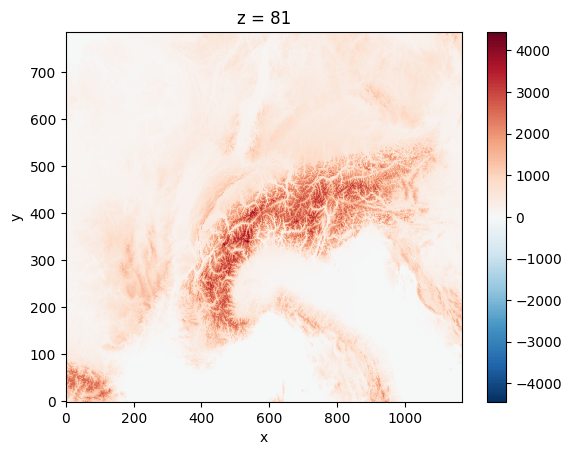

In [17]:
hhl = ds["HHL"].squeeze(drop=True)
hhl.sel(z=81).plot()


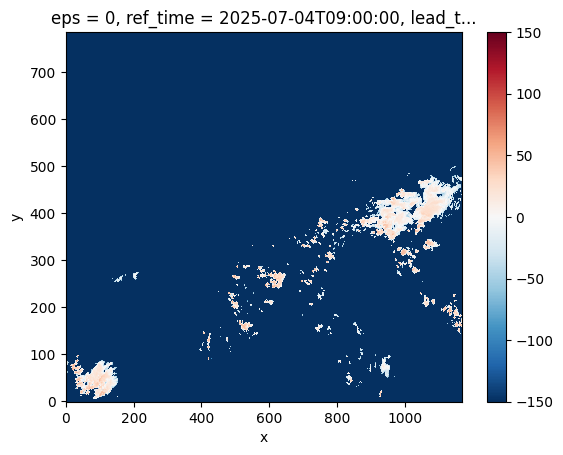

In [18]:
dbz = ds["DBZ"]
dbz.sel(z=40).plot()


## Compute "EchoTop" field

The EchoTop is related to the active core of a thundercloud and is defined as the greatest height at which a radar reflectivity of 15 dBZ is measured.

In [19]:
from meteodatalab.operators.destagger import destagger
from meteodatalab.operators.vertical_interpolation import interpolate_k2any


In [21]:
hfl = destagger(hhl, "z")
# interpolate height to isosurface of radar reflectivity
echo_top = interpolate_k2any(hfl, "high_fold", dbz, [15.0], hfl)
echo_top.plot()

AttributeError: 'list' object has no attribute 'type_of_level'

## Write the field back to FDB

Since `interpolate_k2any` is a generic operator, the metadata has to be updated to maintain consistency with the computed values.

In [ ]:
from meteodatalab import metadata


In [ ]:
# override the GRIB template message metadata
echo_top.attrs |= metadata.override(
    echo_top.message, shortName="ECHOTOPinM", typeOfLevel="echoTopInDBZ"
)


In order to archive back to FDB you need write access to the FDB root directory which is only possible through the designated service account at CSCS.

In [10]:
import os
os.environ["FDB5_HOME"] = '{"type":"local","engine":"toc","schema":"/scratch/mch/trajond/fdb-realtime-lcm/schema","spaces":[{"handler":"Default","roots":[{"path":"/scratch/mch/cosuna/ppp"}]}]}'

mch_model_data.archive_to_fdb(ds["T"])


: 

## Summary

- compute derived variable from direct model output
- update the metadata
- archive the result back to FDB